# Deep Learning - Lab Exercise 2

**WARNING:** you must have finished the first exercise before this one as you will re-use parts of the code.

In the first lab exercise, we built a simple linear classifier.
Although it can give reasonable results on the MNIST dataset (~92.5% of accuracy), deeper neural networks can achieve more the 99% accuracy.
However, it can quickly become really impracical to explicitly code forward and backward passes.
Hence, it is useful to rely on an auto-diff library where we specify the forward pass once, and the backward pass is automatically deduced from the computational graph structure.

In this lab exercise, we will build a small and simple auto-diff lib that mimics the autograd mechanism from Pytorch (of course, we will simplify a lot!)


In [1]:
# import libs that we will use
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from copy import deepcopy

# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

# Data

In [30]:
# Download mnist dataset
if("mnist.pkl.gz" not in os.listdir(".")):
	# this link doesn't work any more,
	# seach on google for the file "mnist.pkl.gz"
	# and download it
	!wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

In [31]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

label: 5


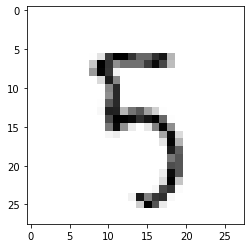

In [32]:
index = 900
label = train_data[1][index]
picture = train_data[0][index]

print("label: %i" % label)
plt.imshow(picture.reshape(28,28), cmap='Greys')

# Computation nodes

Instead of directly manipulating numpy arrays, we will manipulate abstraction that contains:
- a value (i.e. a numpy array)
- a bool indicating if we wish to compute the gradient with respect to the value
- the gradient with respect to the value
- the operation to call during backpropagation

There will be two kind of nodes:
- Tensor: a generic computation node
- Parameter: a computation node that is used to store parameters of the network. Parameters are always leaf nodes, i.e. they cannot be build from other computation nodes.

Our implementation of the backward pass will be really simple and incorrect in the general case (i.e. won't work with computation graph with loops).
We will just apply the derivative function for a given tensor and then call the ones of its antecedents, recursively.
This simple algorithm is good enough for this exercise.

Note that a real implementation of backprop will store temporary values during forward that can be used during backward to improve computation speed. We do not do that here.

In [5]:
class Tensor:
	def __init__(self, data, require_grad = False):
		# test type of data: should be np array
		if isinstance(data, float):
			data = np.array([data,])
		if type(data) != np.ndarray:
			raise RuntimeError("Input should be a numpy array")

		# store data for this tensor
		self.data = data
		self.require_grad = require_grad

		# this values should be set to enable autograd!
		self.gradient = None
		self.d = None
		self.backptr = None

	def zero_grad(self):
		"""
		Set the gradient of thie tensor to 0
		"""
		if self.require_grad:
			self.gradient = np.zeros_like(self.data)

	def accumulate_gradient(self, gradient):
		"""
		Accumulte gradient for this tensor
		"""
		if gradient.shape != self.data.shape:
			raise RuntimeError("Invalid gradient dimension")

		if self.gradient is None:
			self.gradient = np.copy(gradient)
		else:
			self.gradient += gradient

	def backward(self, g = None):
		"""
		The backward pass!
		If g != None, then g is the gradient for the current node.
		i.e. g will be != None only for the loss output.

		You should call the function stored in self.d with correct arguments,
		and then recursively call the backward methods of tensors in the backptr list if:
		1. they require a gradient
		2. they are of type Tensor: check with isinstance(o, Tensor)
		"""
		if not self.require_grad:  # stop right now if this node does not require a gradient
			return

		if g is not None:
			if isinstance(g, float):
				g = np.array([g])
			if type(g) != np.ndarray:
				raise RuntimeError("Gradient should be a numpy array")
			if g.shape != self.data.shape:
				raise RuntimeError("Gradient of different size than the value!")

			self.gradient = g

		self.d(self.backptr, self.gradient)

		for ptr in self.backptr:
			if isinstance(ptr, Tensor) and ptr.require_grad and not isinstance(ptr, Parameter):
				ptr.backward()


class Parameter(Tensor):
	"""
	This class will be used to store parameters of the network only!
	"""
	def __init__(self, data, name = "unamed"):
		super().__init__(data, require_grad = True)
		self.name = name
		self.velocity = 0.

	def backward(self):
		raise RuntimeError("You cannot backprop from a Parameter node")

# Functions

Functions manipulate tensors and build the required information for autograd.
A function returns a Tensor that should have require_grad = True if at least of the arguments require a gradient.

In [6]:
def any_require_grad(l):
	"""
	Input:
	- l: an iterable (e.g. a list)
	Ouput:
	- True if any tensor in the input requires a gradient
	"""
	return any(t.require_grad for t in l)

In [7]:
# Here is an exemple with the ReLU
def relu(x):
	v = np.maximum(0, x.data)

	output = Tensor(v, require_grad = x.require_grad)
	output.d = backward_relu
	output.backptr = [x]

	return output

def backward_relu(backptr, g):
	x, = backptr

	# the gradient is accumulated in the arguments only if required
	if x.require_grad:
		x.accumulate_gradient(g * (x.data > 0))

In [8]:
def tanh(x):
	v = np.tanh(x.data)

	output = Tensor(v, require_grad = x.require_grad)
	output.d = backward_tanh
	output.backptr = [x]

	return output

def backward_tanh(backptr, g):
	x, = backptr

	if x.require_grad:
		x.accumulate_gradient(g * (1 - np.tanh(x.data) ** 2))

Next, we implement the affine transform operation.
You can reuse the code from the first lab exercise, with one major difference: you have to compute the gradient with respect to x too!

In [9]:
def affine_transform(W, b, x):
	v = W.data @ x.data + b.data

	output = Tensor(v, require_grad = True)
	output.d = backward_affine_transform
	output.backptr = [W, b, x]

	return output

def backward_affine_transform(backptr, g):
	W, b, x = backptr

	if W.require_grad:
		W.accumulate_gradient(np.outer(g, x.data))
	if b.require_grad:
		b.accumulate_gradient(g)
	if x.require_grad:
		x.accumulate_gradient(W.data.T @ g)

In [10]:
# we use an underscore because this function does not manipulate tensors:
# it is exactly the same as in the previous exercise
def _softmax(x):
	b = np.array(x).max()
	y = np.exp(np.array(x) - b)
	return y / y.sum()

def nll(x, gold):
	b = np.array(x.data).max()
	y = np.exp(np.array(x.data) - b)
	v = -np.log(y[gold] / y.sum())

	output = Tensor(v, require_grad = True)
	output.d = backward_nll
	output.backptr = [x, gold]

	return output

def backward_nll(backptr, g):
	x, gold = backptr

	g_x = _softmax(x.data)
	g_x[gold] -= 1.

	if x.require_grad:
		x.accumulate_gradient(g_x * g)

# Module

Neural networks or parts of neural networks will be stored in Modules.
They implement method to retrieve all parameters of the network and subnetwork.

In [11]:
class Module:
	def __init__(self):
		raise NotImplemented("")

	def parameters(self):
		ret = []
		for name in dir(self):
			o = self.__getattribute__(name)

			if type(o) is Parameter:
				ret.append(o)
			if isinstance(o, Module) or isinstance(o, ModuleList):
				ret.extend(o.parameters())
		return ret

# if you want to store a list of Parameters or Module,
# you must store them in a ModuleList instead of a python list,
# in order to collect the parameters correctly
class ModuleList(list):
	def parameters(self):
		ret = []
		for m in self:
			if type(m) is Parameter:
				ret.append(m)
			elif isinstance(m, Module) or isinstance(m, ModuleList):
				ret.extend(m.parameters())
		return ret

# Initialization and optimization

In [12]:
def zero_init(b):
	return np.zeros(b.shape[0])

def glorot_init(W):
	range = np.sqrt(6. / (W.shape[0] + W.shape[1]))
	return np.random.uniform(-range, range, size = W.shape)

def kaiming_init(W):
	range = np.sqrt(6. / W.shape[1])
	return np.random.uniform(-range, range, size = W.shape)

In [13]:
# simple gradient descent optimizer
class SGD:
	def __init__(self, params, lr, momentum):
		self.params = params
		self.lr = lr
		self.momentum = momentum

	def step(self):
		for p in self.params:
			p.velocity = (self.momentum * p.velocity) + ((1. - self.momentum) * p.gradient)
			p.data[:] = p.data - self.lr * p.velocity

	def zero_grad(self):
		for p in self.params:
			p.zero_grad()

# Networks and training loop

We first create a simple linear classifier, similar to the first lab exercise.

In [14]:
class LinearNetwork(Module):
	def __init__(self, dim_input, dim_output):
		# build the parameters
		self.W = Parameter(np.ndarray((dim_output, dim_input)))
		self.b = Parameter(np.ndarray((dim_output,)))

		self.init_parameters()

	def init_parameters(self):
		# init parameters of the network (i.e W and b)
		self.W.data = glorot_init(self.W.data)
		self.b.data = zero_init(self.b.data)

	def forward(self, x):
		return affine_transform(self.W, self.b, x)

We will train several neural networks.
Therefore, we encapsulate the training loop in a function.

**warning**: you have to call optimizer.zero_grad() before each backward pass to reinitialize the gradient of the parameters!

In [15]:
def getDimDataset(data):
	nb_data = data[0].shape[0]
	nb_feature = data[0].shape[1]
	nb_label = len(set(data[1]))
	return nb_data, nb_feature, nb_label

In [16]:
def shuffle(data):
	index_list = np.array([i for i in range(len(data[0]))])
	np.random.shuffle(index_list)
	data[0] = data[0][index_list]
	data[1] = data[1][index_list]

In [17]:
def test(network, data):

	loss_sum = 0.
	nb_success = 0
	nb_data, nb_feature, nb_label = getDimDataset(data)
	x = data[0]
	gold = data[1]

	for i in range(nb_data):

		y = network.forward(Tensor(x[i], require_grad = False))
		o = _softmax(y.data)

		loss_sum += nll(y, gold[i]).data

		if o.argmax() == gold[i]:
			nb_success += 1

	return nb_success / nb_data, loss_sum / nb_data

In [34]:
def train(network, optimizer, train_data, dev_data, epochs, batch_size):

	nb_data, nb_feature, nb_label = getDimDataset(train_data)
	best_dev = 100000.
	best_network = deepcopy(network)

	for epoch in range(epochs):

		loss_sum = 0
		shuffle(train_data)
		x = train_data[0]
		gold = train_data[1]

		for batch in range(int(nb_data / batch_size)):

			loss_sum = 0.
			nb_success = 0

			for i in range(batch * batch_size, (batch + 1) * batch_size):

				# Forward
				y = network.forward(Tensor(x[i], require_grad = False))
				o = _softmax(y.data)
				loss = nll(y, gold[i])
				loss_sum += loss.data

				if o.argmax() == gold[i]:
					nb_success += 1

				# Backward
				optimizer.zero_grad()
				loss.backward(1.)

				# Update
				optimizer.step()

			# Tests
			loss = loss_sum / batch_size
			accuracy = nb_success / batch_size
			dev_accuracy, dev_loss = test(network, dev_data)

			# Save the best model
			if dev_loss < best_dev :
				best_network = deepcopy(network)
				best_dev = dev_loss

			# Print
			msg = "Epoch %i | batch %i | train loss: %.2f | train accuracy: %.1f%% | dev loss: %.2f | dev accuracy: %.1f%%" % (epoch + 1, batch + 1, loss, accuracy * 100., dev_loss, dev_accuracy * 100.)
			if batch == int(nb_data / batch_size) - 1: print(msg)
			else: print(msg, end = "\r")

	return best_network

In [21]:
epochs = 10
batch_size = 5000
nb_data, nb_feature, nb_label = getDimDataset(train_data)

network = LinearNetwork(nb_feature, nb_label)
optimizer = SGD(network.parameters(), 0.01, 0.9)

print("Training...\n")
network = train(network, optimizer, train_data, dev_data, epochs, batch_size)

print("\nTesting...\n")
test_accuracy, test_loss = test(network, test_data)

print("Test accuracy: %.1f%%" % (test_accuracy * 100.))

Training...

Epoch 1 | batch 10 | train loss: 0.33 | train accuracy: 90.4% | dev loss: 0.29 | dev accuracy: 91.8%
Epoch 2 | batch 10 | train loss: 0.33 | train accuracy: 90.9% | dev loss: 0.29 | dev accuracy: 92.0%
Epoch 3 | batch 10 | train loss: 0.28 | train accuracy: 91.7% | dev loss: 0.28 | dev accuracy: 91.9%
Epoch 4 | batch 10 | train loss: 0.28 | train accuracy: 91.9% | dev loss: 0.27 | dev accuracy: 92.4%
Epoch 5 | batch 10 | train loss: 0.29 | train accuracy: 92.0% | dev loss: 0.27 | dev accuracy: 92.4%
Epoch 6 | batch 10 | train loss: 0.31 | train accuracy: 91.9% | dev loss: 0.28 | dev accuracy: 92.4%
Epoch 7 | batch 10 | train loss: 0.27 | train accuracy: 92.2% | dev loss: 0.28 | dev accuracy: 92.3%
Epoch 8 | batch 10 | train loss: 0.29 | train accuracy: 91.3% | dev loss: 0.28 | dev accuracy: 92.0%
Epoch 9 | batch 10 | train loss: 0.29 | train accuracy: 91.8% | dev loss: 0.27 | dev accuracy: 92.6%
Epoch 10 | batch 10 | train loss: 0.26 | train accuracy: 92.4% | dev loss: 0.2

After you finished the linear network, you can move to a deep network!

In [22]:
class DeepNetwork(Module):
	def __init__(self, dim_input, dim_output, hidden_dim, n_layers, tanh = False):
		self.W = ModuleList()
		self.b = ModuleList()
		self.n_layers = n_layers
		self.tanh = tanh

		for layer in range(n_layers):

			if layer == 0:
				weights = Parameter(np.zeros((hidden_dim, dim_input)))
			else:
				weights = Parameter(np.zeros((hidden_dim, hidden_dim)))

			bias = Parameter(np.zeros((hidden_dim,)))

			self.W.append(weights)
			self.b.append(bias)

		self.output_proj = Parameter(np.zeros((dim_output, hidden_dim)))
		self.output_bias = Parameter(np.zeros((dim_output,)))

		self.init_parameters()

	def init_parameters(self):

		for weight in self.W.parameters():
			if self.tanh:
				weight.data = glorot_init(weight.data)
			else:
				weight.data = kaiming_init(weight.data)

		for bias in self.b.parameters():
			if self.tanh:
				bias.data = zero_init(bias.data)
			else:
				bias.data = zero_init(bias.data) + 0.01

		if self.tanh:
			self.output_proj.data = glorot_init(self.output_proj.data)
		else:
			self.output_proj.data = kaiming_init(self.output_proj.data)

		if self.tanh:
			self.output_bias.data = zero_init(self.output_bias.data)
		else:
			self.output_bias.data = zero_init(self.output_bias.data) + 0.01

	def forward(self, x):

		for i in range(self.n_layers):

			x = affine_transform(self.W.parameters()[i], self.b.parameters()[i], x)

			if self.tanh:
				x = tanh(x)
			else:
				x = relu(x)

		return affine_transform(self.output_proj, self.output_bias, x)

In [35]:
epochs = 20
batch_size = 10000
nb_data, nb_feature, nb_label = getDimDataset(train_data)

network = DeepNetwork(nb_feature, nb_label, 128, 1, tanh = False)
optimizer = SGD(network.parameters(), 0.01, 0.9)

print("Training...\n")
network = train(network, optimizer, train_data, dev_data, epochs, batch_size)

print("\nTesting...\n")
test_accuracy, test_loss = test(network, test_data)

print("Test accuracy: %.1f%%" % (test_accuracy * 100.))

Training...

Epoch 1 | batch 5 | train loss: 0.15 | train accuracy: 95.5% | dev loss: 0.12 | dev accuracy: 96.5%
Epoch 2 | batch 5 | train loss: 0.10 | train accuracy: 97.3% | dev loss: 0.10 | dev accuracy: 96.9%
Epoch 3 | batch 5 | train loss: 0.08 | train accuracy: 97.5% | dev loss: 0.09 | dev accuracy: 97.1%
Epoch 4 | batch 5 | train loss: 0.06 | train accuracy: 98.1% | dev loss: 0.09 | dev accuracy: 97.2%
Epoch 5 | batch 5 | train loss: 0.05 | train accuracy: 98.4% | dev loss: 0.09 | dev accuracy: 97.3%
Epoch 6 | batch 5 | train loss: 0.04 | train accuracy: 98.7% | dev loss: 0.09 | dev accuracy: 97.6%
Epoch 7 | batch 5 | train loss: 0.03 | train accuracy: 99.1% | dev loss: 0.09 | dev accuracy: 97.5%
Epoch 8 | batch 5 | train loss: 0.02 | train accuracy: 99.3% | dev loss: 0.10 | dev accuracy: 97.5%
Epoch 9 | batch 5 | train loss: 0.02 | train accuracy: 99.4% | dev loss: 0.09 | dev accuracy: 97.8%
Epoch 10 | batch 5 | train loss: 0.01 | train accuracy: 99.6% | dev loss: 0.09 | dev ac

## Bonus

You can try to implement a momentum SGD optimizer! Note that you have to keep track of the velocity for each parameter in the optimizer.
